In [1]:
import pandas as pd
import polars as pl
from data import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pyarrow
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import sys
import numpy as np
from scipy import stats
from typing import cast
from utils import *
import wrds

# 0. Preprocessing

In [2]:
full_data = pl.read_csv(get_data_file_path("signed_predictors_all_wide.csv"), dtypes=ALL_DATA_ENTRY_SCHEMA)
full_data = full_data.sort(by=["permno", "yyyymm"], maintain_order=True)
full_data = full_data.with_columns(full_data["yyyymm"].str.to_date("%Y%m").alias("date"))
full_data

permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date
10000,"""198512""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null,1985-12-01
10000,"""198601""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,-0.005234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-1.475907,-9.686575,1986-01-01
10000,"""198602""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,-0.003488,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.7852e-8,null,25.7143,-1.178655,-9.389323,1986-02-01
10000,"""198603""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,-0.002715,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0234e-7,null,-36.5385,-1.490091,-9.700759,1986-03-01
10000,"""198604""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,0.000877,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.4675e-8,null,9.8592,-1.386294,-9.627207,1986-04-01
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,"""202401""",null,null,-0.003877,0.016862,null,null,null,null,null,null,null,null,-0.325232,null,null,null,null,null,null,null,null,-1.838476,null,null,null,null,null,null,0.598015,-1.480804,null,-0.098042,null,null,0.097266,…,0.0,0.288081,-0.223286,null,null,null,null,null,null,0.040382,null,null,null,-0.109511,null,null,null,null,null,-0.251513,null,null,null,null,null,null,null,null,null,0.698178,null,null,null,null,null,null,2024-01-01
93436,"""202402""",null,null,-0.003877,0.016862,null,null,null,null,null,null,null,null,-0.325232,null,null,null,null,null,null,null,null,-1.838476,null,null,null,null,null,null,0.598015,-1.480804,null,-0.098042,null,null,0.097266,…,0.0,0.288081,-0.223286,null,null,null,null,null,null,0.040382,null,null,null,-0.109511,null,null,null,null,null,-0.251513,null,null,null,null,null,null,null,null,null,0.698178,n

In [4]:
MIN_DATE = full_data["date"].min()
MAX_DATE = full_data["date"].max()
MIN_PERMNO = full_data["permno"].min()
MAX_PERMNO = full_data["permno"].max()

In [7]:
db = wrds.Connection(wrds_username=get_env("WRDS_USERNAME"))

# Query to get the stock returns
query = f"""
SELECT permno, date, ret
FROM crsp.msf
WHERE permno BETWEEN {MIN_PERMNO} AND {MAX_PERMNO}
AND date BETWEEN '{MIN_DATE.strftime("%Y-%m-%d")}' AND '{MAX_DATE.strftime("%Y-%m-%d")}'
"""

# Execute the query
all_returns_data = db.raw_sql(query)

# Close the connection
db.close()

Loading library list...
Done


In [17]:
all_returns_data

,permno,date,ret
0,10000,1985-12-31,NaN
1,10000,1986-01-31,NaN
2,10000,1986-02-28,-0.257143
3,10000,1986-03-31,0.365385
4,10000,1986-04-30,-0.098592
...,...,...,...
37348,93436,2023-08-31,-0.034962
37349,93436,2023-09-29,-0.030456
37350,93436,2023-10-31,-0.197346
37351,93436,2023-11-30,0.195379


In [12]:
db = wrds.Connection(wrds_username=get_env("WRDS_USERNAME"))

# Query to get the stock returns
query = f"""
SELECT permno, mthcaldt, mthret
FROM crsp.msf_v2
WHERE permno BETWEEN {MIN_PERMNO} AND {MAX_PERMNO}
AND mthcaldt BETWEEN '{MIN_DATE.strftime("%Y-%m-%d")}' AND '{MAX_DATE.strftime("%Y-%m-%d")}'
"""

# Execute the query
all_returns_data_v2 = db.raw_sql(query)

# Close the connection
db.close()

Loading library list...
Done


In [23]:
all_returns_data_v2 = pl.DataFrame(all_returns_data_v2)
all_returns_data_v2

permno,mthcaldt,mthret
i64,date,f64
10000,1986-01-31,0.707317
10000,1986-02-28,-0.257143
10000,1986-03-31,0.365385
10000,1986-04-30,-0.098592
10000,1986-05-30,-0.222656
…,…,…
93436,2023-08-31,-0.034962
93436,2023-09-29,-0.030456
93436,2023-10-31,-0.197346


In [ ]:
all_returns_data.to_csv(get_data_file_path("all_returns_values.csv")) # type: ignore

In [ ]:
all_returns_df = pl.read_csv(get_data_file_path("all_returns_values.csv"), dtypes={"permno": pl.Int64, "date": pl.Date, "ret": pl.Float64})

In [ ]:
all_returns_df

,permno,date,ret
i64,i64,date,f64
0,10000,1986-01-31,null
1,10000,1986-02-28,-0.257143
2,10000,1986-03-31,0.365385
3,10000,1986-04-30,-0.098592
4,10000,1986-05-30,-0.222656
…,…,…,…
487268,93436,2023-08-31,-0.034962
487269,93436,2023-09-29,-0.030456
487270,93436,2023-10-31,-0.197346


In [ ]:
all_returns_df.insert_column(2, pl.Series("yyyymm", all_returns_df.get_column("date").apply(lambda x: x.strftime("%Y%m"))))

/var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_99231/1299984043.py:1: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  all_returns_df.insert_column(2, pl.Series("yyyymm", all_returns_df.get_column("date").apply(lambda x: x.strftime("%Y%m"))))
/var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_99231/1299984043.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  all_returns_df.insert_column(2, pl.Series("yyyymm", all_returns_df.get_column("date").apply(lambda x: x.strftime("%Y%m"))))


,permno,yyyymm,date,ret
i64,i64,str,date,f64
0,10000,"""198601""",1986-01-31,null
1,10000,"""198602""",1986-02-28,-0.257143
2,10000,"""198603""",1986-03-31,0.365385
3,10000,"""198604""",1986-04-30,-0.098592
4,10000,"""198605""",1986-05-30,-0.222656
…,…,…,…,…
487268,93436,"""202308""",2023-08-31,-0.034962
487269,93436,"""202309""",2023-09-29,-0.030456
487270,93436,"""202310""",2023-10-31,-0.197346


In [ ]:
all_returns_df.drop_in_place("")

""
i64
0
1
2
3
4
…
487268
487269
487270


In [ ]:
all_returns_df

permno,yyyymm,date,ret
i64,str,date,f64
10000,"""198601""",1986-01-31,null
10000,"""198602""",1986-02-28,-0.257143
10000,"""198603""",1986-03-31,0.365385
10000,"""198604""",1986-04-30,-0.098592
10000,"""198605""",1986-05-30,-0.222656
…,…,…,…
93436,"""202308""",2023-08-31,-0.034962
93436,"""202309""",2023-09-29,-0.030456
93436,"""202310""",2023-10-31,-0.197346


In [ ]:
full_data = full_data.join(all_returns_df, on=("permno", "yyyymm"))

In [ ]:
full_data.write_csv(get_data_file_path("COMPLETE_DATASET.csv"))

In [ ]:
data = pl.read_csv(get_data_file_path("signed_predictors_dl_wide.csv"), dtypes=SIGNED_PREDICTORS_ENTRY_SCHEMA)
# data = pd.read_csv(get_data_file_path("signed_predictors_dl_wide.csv"), dtype=SIGNED_PREDICTORS_ENTRY_SCHEMA)

In [ ]:
data

permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,…,ShareVol,ShortInterest,SmileSlope,Spinoff,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10000,"""198601""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,-1.0,null,null,0.0,null,null,null,null,null,null,null,null,null,null,-0.005234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
10000,"""198602""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,-1.0,null,null,0.0,null,null,null,null,null,null,null,null,null,null,-0.003488,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.7852e-8,null
10000,"""198603""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,0.0,null,null,null,null,null,null,null,null,null,null,-0.002715,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0234e-7,null
10000,"""198604""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,0.000877,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.4675e-8,null
10000,"""198605""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,0.008818,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.6496e-8,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,"""202401""",null,null,-0.003877,0.016862,null,null,null,null,null,null,null,null,-0.325232,null,null,null,null,null,null,null,null,-1.838476,null,null,null,null,null,null,0.598015,-1.480804,null,-0.098042,null,null,0.097266,…,null,null,null,null,0.0,0.288081,-0.223286,null,null,null,null,null,null,0.040382,null,null,null,-0.109511,null,null,null,null,null,-0.251513,null,null,null,null,null,null,null,null,null,0.698178,null,null,null
93436,"""202402""",null,null,-0.003877,0.016862,null,null,null,null,null,null,null,null,-0.325232,null,null,null,null,null,null,null,null,-1.838476,null,null,null,null,null,null,0.598015,-1.480804,null,-0.098042,null,null,0.097266,…,null,null,null,null,0.0,0.288081,-0.223286,null,null,null,null,null,null,0.040382,null,null,null,-0.109511,null,null,null,null,null,-0.251513,null,null,null,null,null,null,null,null,null,0.698178,null,null,null
93436,"""202403""",null,null,-0.

In [ ]:
# Handle missing values
imputer = SimpleImputer(strategy="mean")
all_predictors_imputed = imputer.fit_transform(data)

In [ ]:
with open(get_data_file_path("all_predictors_imputed.pkl"), "wb") as f:
    pickle.dump(all_predictors_imputed, f)

In [ ]:
with open(get_data_file_path("all_predictors_imputed.pkl"), "rb") as f:
    all_predictors_imputed = pickle.load(f)

In [ ]:
data_imputed = pl.DataFrame(all_predictors_imputed, schema=SIGNED_PREDICTORS_ENTRY_SCHEMA)

In [ ]:
_ = data_imputed.replace("yyyymm", data_imputed.get_column("yyyymm").str.strip_chars(".0"))
del _

/var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_19284/83776391.py:1: DeprecationWarning: `replace` is deprecated. DataFrame.replace is deprecated and will be removed in a future version. Please use
    df = df.with_columns(new_column.alias(column_name))
instead.
  _ = data_imputed.replace("yyyymm", data_imputed.get_column("yyyymm").str.strip_chars(".0"))


In [ ]:
with open(get_data_file_path("all_predictors_imputed_df.pkl"), "wb") as f:
    pickle.dump(data_imputed, f)

In [ ]:
with open(get_data_file_path("all_predictors_imputed_df.pkl"), "rb") as f:
    data_imputed: pl.DataFrame = pickle.load(f)

In [ ]:
data_imputed

permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,…,ShareVol,ShortInterest,SmileSlope,Spinoff,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10000,"""198601""",3.679108,-165.572065,0.000082,0.031046,0.483201,14.8865,9.263089,0.075071,18.541335,1.006447,0.756109,0.00265,-0.176024,-0.726098,2.955261,0.010867,0.989357,0.973176,-0.000942,0.641241,0.016827,-4.025639,-2575.475564,0.093091,0.009326,-0.009441,0.163636,12.959522,-0.05317,-1.314422,0.4765,-0.010126,1184.389561,-0.145632,0.003044,…,-1.0,-32793.262891,-0.005706,0.0,0.287186,1.166194,-0.003901,0.215255,0.352181,-0.86924,-0.170444,-4.679102,-0.005833,-0.062235,-0.005234,0.004548,0.000138,-0.098494,0.000396,-0.000534,-16.780281,-3.378635,-3.0530e10,-0.036986,1.725571,1.59892,-5.7231e-11,0.010997,-0.007297,-0.002534,0.17759,-0.067404,-0.168298,0.692479,1.483897,1.569696,1.417246
10000,"""198602""",3.679108,-165.572065,0.000082,0.031046,0.483201,14.8865,9.263089,0.075071,18.541335,1.006447,0.756109,0.00265,-0.176024,-0.726098,2.955261,0.010867,0.989357,0.973176,-0.000942,0.641241,0.016827,-4.025639,-2575.475564,0.093091,0.009326,-0.009441,0.163636,12.959522,-0.05317,-1.314422,0.4765,-0.010126,1184.389561,-0.145632,0.003044,…,-1.0,-32793.262891,-0.005706,0.0,0.287186,1.166194,-0.003901,0.215255,0.352181,-0.86924,-0.170444,-4.679102,-0.005833,-0.062235,-0.003488,0.004548,0.000138,-0.098494,0.000396,-0.000534,-16.780281,-3.378635,-3.0530e10,-0.036986,1.725571,1.59892,-5.7231e-11,0.010997,-0.007297,-0.002534,0.17759,-0.067404,-0.168298,0.692479,1.483897,4.7852e-8,1.417246
10000,"""198603""",3.679108,-165.572065,0.000082,0.031046,0.483201,14.8865,9.263089,0.075071,18.541335,1.006447,0.756109,0.00265,-0.176024,-0.726098,2.955261,0.010867,0.989357,0.973176,-0.000942,0.641241,0.016827,-4.025639,-2575.475564,0.093091,0.009326,-0.009441,0.163636,12.959522,-0.05317,-1.314422,0.4765,-0.010126,1184.389561,-0.145632,0.003044,…,0.0,-32793.262891,-0.005706,0.0,0.287186,1.166194,-0.003901,0.215255,0.352181,-0.86924,-0.170444,-4.679102,-0.005833,-0.062235,-0.002715,0.004548,0.000138,-0.098494,0.000396,-0.000534,-16.780281,-3.378635,-3.0530e10,-0.036986,1.725571,1.59892,-5.7231e-11,0.010997,-0.007297,-0.002534,0.17759,-0.067404,-0.168298,0.692479,1.483897,1.0234e-7,1.417246
10000,"""198604""",3.679108,-165.572065,0.000082,0.031046,0.483201,14.8865,9.263089,0.075071,18.541335,1.006447,0.756109,0.00265,-0.176024,-0.726098,2.955261,0.010867,0.989357,0.973176,-0.000942,0.641241,0.016827,-4.025639,-2575.475564,0.093091,0.009326,-0.009441,0.163636,12.959522,-0.05317,-1.314422,0.4765,-0.010126,1184.389561,-0.145632,0.003044,…,-0.30328,-32793.262891,-0.005706,0.0,0.287186,1.166194,-0.003901,0.215255,0.352181,-0.86924,-0.170444,-4.679102,-0.005833,-0.062235,0.000877,0.004548,0.000138,-0.098494,0.000396,-0.000534,-16.780281,-3.378635,-3.0530e10,-0.036986,1.725571,1.59892,-5.7231e-11,0.010997,-0.007297,-0.002534,0.17759,-0.067404,-0.168298,0.692479,1.483897,7.4675e-8,1.417246
10000,"""198605""",3.679108,-165.572065,0.000082,0.031046,0.483201,14.8865,9.263089,0.075071,18.541335,1.006447,0.756109,0.00265,-0.176024,-0.726098,2.955261,0.010867,0.989357,0.973176,-0.000942,0.641241

In [ ]:
ret = pl.read_csv(get_data_file_path("PredictorPortsFull.csv"), null_values=("NA",), dtypes=PREDICTOR_PORTS_ENTRY_SCHEMA)

In [ ]:
ret

signalname,port,date,ret,signallag,Nlong,Nshort
str,str,date,f64,f64,i64,i64
"""AM""","""01""",1951-07-31,7.661648,0.681619,67,0
"""AM""","""01""",1951-08-31,4.273648,0.639816,67,0
"""AM""","""01""",1951-09-28,1.31527,0.617079,67,0
"""AM""","""01""",1951-10-31,-3.94298,0.612266,67,0
"""AM""","""01""",1951-11-30,1.02867,0.63771,67,0
…,…,…,…,…,…,…
"""zerotradeAlt12""","""LS""",2022-08-31,-1.467892,null,491,492
"""zerotradeAlt12""","""LS""",2022-09-30,4.607782,null,490,491
"""zerotradeAlt12""","""LS""",2022-10-31,-5.81855,null,492,492


In [ ]:
ret.insert_column(3, pl.Series("yyyymm", ret.get_column("date").apply(lambda x: x.strftime("%Y%m"))))

/var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_89187/3833254137.py:1: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  ret.insert_column(3, pl.Series("yyyymm", ret.get_column("date").apply(lambda x: x.strftime("%Y%m"))))
/var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_89187/3833254137.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  ret.insert_column(3, pl.Series("yyyymm", ret.get_column("date").apply(lambda x: x.strftime("%Y%m"))))


signalname,port,date,yyyymm,ret,signallag,Nlong,Nshort
str,str,date,str,f64,f64,i64,i64
"""AM""","""01""",1951-07-31,"""195107""",7.661648,0.681619,67,0
"""AM""","""01""",1951-08-31,"""195108""",4.273648,0.639816,67,0
"""AM""","""01""",1951-09-28,"""195109""",1.31527,0.617079,67,0
"""AM""","""01""",1951-10-31,"""195110""",-3.94298,0.612266,67,0
"""AM""","""01""",1951-11-30,"""195111""",1.02867,0.63771,67,0
…,…,…,…,…,…,…,…
"""zerotradeAlt12""","""LS""",2022-08-31,"""202208""",-1.467892,null,491,492
"""zerotradeAlt12""","""LS""",2022-09-30,"""202209""",4.607782,null,490,491
"""zerotradeAlt12""","""LS""",2022-10-31,"""202210""",-5.81855,null,492,492


In [ ]:
ret

signalname,port,date,yyyymm,ret,signallag,Nlong,Nshort
str,str,date,str,f64,f64,i64,i64
"""AM""","""01""",1951-07-31,"""195107""",7.661648,0.681619,67,0
"""AM""","""01""",1951-08-31,"""195108""",4.273648,0.639816,67,0
"""AM""","""01""",1951-09-28,"""195109""",1.31527,0.617079,67,0
"""AM""","""01""",1951-10-31,"""195110""",-3.94298,0.612266,67,0
"""AM""","""01""",1951-11-30,"""195111""",1.02867,0.63771,67,0
…,…,…,…,…,…,…,…
"""zerotradeAlt12""","""LS""",2022-08-31,"""202208""",-1.467892,null,491,492
"""zerotradeAlt12""","""LS""",2022-09-30,"""202209""",4.607782,null,490,491
"""zerotradeAlt12""","""LS""",2022-10-31,"""202210""",-5.81855,null,492,492


<hr>

# MAIN START

## 1. Analysis of data

Retrieving the previously computed data and analyzing it.

In [2]:
# Retrieve data from csv file
full_data = pl.read_csv(get_data_file_path("COMPLETE_DATASET.csv"), dtypes=ALL_DATA_ENTRY_SCHEMA)

In [3]:
# Peek at data
full_data

permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,…,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date,ret
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
10000,"""198601""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,-0.005234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-1.475907,-9.686575,"""1986-01-31""",null
10000,"""198602""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,-0.003488,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.7852e-8,null,25.7143,-1.178655,-9.389323,"""1986-02-28""",-0.257143
10000,"""198603""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,-0.002715,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0234e-7,null,-36.5385,-1.490091,-9.700759,"""1986-03-31""",0.365385
10000,"""198604""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,0.000877,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.4675e-8,null,9.8592,-1.386294,-9.627207,"""1986-04-30""",-0.098592
10000,"""198605""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,0.008818,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.6496e-8,null,22.2656,-1.134423,-9.375336,"""1986-05-30""",-0.222656
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93433,"""201005""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null,"""2010-05-28""",null
93434,"""201005""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null,"""2010-05-28""",null
93434,"""202

In [4]:
# Get number of nulls in each column
full_data.null_count()

permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,…,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date,ret
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,1373556,2442675,1564337,1264573,3332414,3378542,3457103,2731797,3194692,1879470,2442675,1134594,1254031,1624757,1334089,1387569,666077,986042,988830,2080923,326946,1038824,3154180,1919110,1373556,2821927,1780683,1389489,1834666,1356206,2970493,1253989,1616836,3331035,1271991,…,1317559,1376996,2313046,3043760,1695464,437438,733847,922172,1313412,345432,1513287,2689323,1255987,2689323,2689323,2700697,1780924,1919576,1075377,1920323,1919371,2437845,2840946,1481410,2987944,3363441,3029065,1924475,2538756,331339,216923,512011,0,92818,92818,0,119315


In [5]:
# Get percentage of non-null elements in each column
full_data.count() / len(full_data)

permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,…,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date,ret
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,0.606123,0.299546,0.551415,0.637375,0.044407,0.031179,0.008651,0.216638,0.0839,0.461049,0.299546,0.674647,0.640398,0.53409,0.617441,0.602105,0.808998,0.717246,0.716446,0.403281,0.906246,0.70211,0.095517,0.449682,0.606123,0.190793,0.489377,0.601554,0.473897,0.611098,0.14819,0.64041,0.536361,0.044802,0.635248,…,0.622181,0.605137,0.336718,0.12718,0.513814,0.874562,0.789564,0.735561,0.62337,0.900945,0.566054,0.228818,0.639837,0.228818,0.228818,0.225556,0.489308,0.449548,0.691628,0.449334,0.449607,0.300931,0.185339,0.575195,0.143186,0.03551,0.131394,0.448143,0.271994,0.904986,0.937796,0.853177,1.0,0.973384,0.973384,1.0,0.965786


## 2. Cleaning of nulls

Removing columns with a high number of nulls.

In [6]:
def drop_high_null_columns(data: pl.DataFrame, /, *, null_threshold: float) -> pl.DataFrame:
    """Function that returns a new dataframe where columns exceeding a certain percentage of nulls are dropped.
    The function is out-of-place and does not modify the original data.

    :param data: The dataframe to analyze.
    :param null_threshold: The threshold of nulls to use, columns with a higher percentage will be dropped in the result.
    :return: The dataframe with high-nulls columns dropped.
    """
    if null_threshold < 0.0 or null_threshold > 1.0:
        raise ValueError("Null threshold should be between 0 and 1")
    missing_percentage = data.select(pl.all().is_null().mean()).to_pandas().iloc[0]
    columns_to_drop = missing_percentage[missing_percentage > null_threshold].index
    return data.drop(columns_to_drop)

In [7]:
# Drop columns with over 50% of nulls
full_data = drop_high_null_columns(full_data, null_threshold=0.5)

In [8]:
# Peek new data
full_data

permno,yyyymm,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BidAskSpread,BookLeverage,CF,CashProd,ChEQ,ChInv,ChInvIA,ChNNCOA,ChNWC,ChTax,ConvDebt,CoskewACX,Coskewness,CredRatDG,DebtIssuance,DelCOA,DelCOL,DelEqu,DelFINL,DelLTI,DelNetFin,DivInit,DivOmit,DolVol,…,OPLeverage,PctAcc,PctTotAcc,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,RDIPO,RDS,RealizedVol,ResidualMomentum,ReturnSkew,ReturnSkew3F,RoE,SP,ShareIss1Y,ShareRepurchase,Spinoff,Tax,TotalAccruals,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dNoa,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date,ret
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
10000,"""198601""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,…,null,null,null,null,null,null,null,null,-0.065278,null,-2.23832,-2.103353,null,null,null,null,0.0,null,null,null,null,null,null,null,-0.005234,null,null,null,null,null,null,null,0.0,-1.475907,-9.686575,"""1986-01-31""",null
10000,"""198602""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,…,null,null,null,null,null,null,null,null,-0.031004,null,0.729555,0.810187,null,null,null,null,0.0,null,null,null,null,null,null,null,-0.003488,null,null,null,null,null,4.7852e-8,null,25.7143,-1.178655,-9.389323,"""1986-02-28""",-0.257143
10000,"""198603""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.255134,…,null,null,null,null,null,null,null,null,-0.044548,null,-1.6879,-1.038325,null,null,null,null,0.0,null,null,null,null,null,null,null,-0.002715,null,null,null,null,null,1.0234e-7,null,-36.5385,-1.490091,-9.700759,"""1986-03-31""",0.365385
10000,"""198604""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,1.3126723,…,null,null,null,null,null,null,null,null,-0.011246,null,0.276167,0.068097,null,null,null,null,0.0,null,null,null,null,null,null,null,0.000877,null,null,null,null,null,7.4675e-8,null,9.8592,-1.386294,-9.627207,"""1986-04-30""",-0.098592
10000,"""198605""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.737386,…,null,null,null,null,null,null,null,null,-0.038863,null,-1.289032,-0.738724,null,null,null,null,0.0,null,null,null,null,null,null,null,0.008818,null,null,null,null,null,7.6496e-8,null,22.2656,-1.134423,-9.375336,"""1986-05-30""",-0.222656
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93433,"""201005""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null,"""2010-05-28""",null
93434,"""201005""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.

In [9]:
# Get percentage of non-null elements in each column
full_data.count() / len(full_data)

permno,yyyymm,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BidAskSpread,BookLeverage,CF,CashProd,ChEQ,ChInv,ChInvIA,ChNNCOA,ChNWC,ChTax,ConvDebt,CoskewACX,Coskewness,CredRatDG,DebtIssuance,DelCOA,DelCOL,DelEqu,DelFINL,DelLTI,DelNetFin,DivInit,DivOmit,DolVol,…,OPLeverage,PctAcc,PctTotAcc,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,RDIPO,RDS,RealizedVol,ResidualMomentum,ReturnSkew,ReturnSkew3F,RoE,SP,ShareIss1Y,ShareRepurchase,Spinoff,Tax,TotalAccruals,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dNoa,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date,ret
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,0.606123,0.551415,0.637375,0.674647,0.640398,0.53409,0.617441,0.602105,0.808998,0.717246,0.716446,0.906246,0.70211,0.606123,0.601554,0.611098,0.64041,0.536361,0.635248,0.637346,0.613077,0.702679,0.855454,0.868442,0.526879,0.552492,0.64041,0.637375,0.639849,0.635295,0.64041,0.635295,0.708684,0.708684,0.930882,…,0.701142,0.660432,0.611556,0.864119,0.864119,0.8458,0.702679,0.606669,0.938747,0.657581,0.933662,0.937246,0.702095,0.604698,0.617642,0.702679,0.708684,0.622181,0.605137,0.513814,0.874562,0.789564,0.735561,0.62337,0.900945,0.566054,0.639837,0.691628,0.575195,0.904986,0.937796,0.853177,1.0,0.973384,0.973384,1.0,0.965786


## 3. Imputation of data

We're using `Global BF-XS` to impute the data, the best performing data imputation method according to the paper.

In [10]:
def _pca_impute(data: pl.DataFrame, /, *, n_components: int) -> pl.DataFrame:
    logger = get_logger("PCA Impute")
    logger.debug("Starting PCA imputing...")

    # Removing str columns
    data_dropped = data.drop("permno", "yyyymm", "date")

    # Normalizing
    data_mean = data_dropped.select(pl.all().mean()).to_numpy()
    data_std = data_dropped.select(pl.all().std()).to_numpy()
    data_normalized = data_dropped.with_columns([(pl.all() - pl.all().mean()) / pl.all().std()])

    # Fit PCA
    pca = PCA(n_components=n_components, svd_solver="full")
    zero_filled_pd = data_normalized.fill_nan(0).fill_null(0).to_pandas()
    logger.debug("Starting PCA fit transformation...")
    data_pca = pca.fit_transform(zero_filled_pd)

    # Inverse transform to get back to original space
    logger.debug("Starting inverse PCA transformation...")
    data_filled = pca.inverse_transform(data_pca)
    logger.debug("Computing data filled...")
    data_filled = data_filled * data_std + data_mean

    # Impute missing values
    logger.debug("Converting to numpy...")
    data_np = data_dropped.to_numpy()
    logger.debug("Filtering data filled...")
    data_imputed_np = np.where(np.isnan(data_np), data_filled, data_np)

    # Convert back to Polars DataFrame
    logger.debug("Returning as polars dataframe...")
    return pl.DataFrame(data_imputed_np, schema=data_dropped.columns, nan_to_null=True)


def _ridge_time_series_impute(data: pl.DataFrame, /, *, alpha: float) -> pl.DataFrame:
    logger = get_logger("Ridge Time Series Impute")
    logger.debug("Starting Ridge Time Series Imputation...")
    data_imputed = data.clone()

    # Loop through all columns
    for col in data.columns:
        mask = data[col].is_null()
        if mask.sum() == 0:
            continue

        logger.debug("Sum not 0...")
        train_data = data_imputed.filter(~mask).drop(col)
        train_target = data_imputed.filter(~mask).select(col)
        test_data = data_imputed.filter(mask).drop(col)

        # Convert Polars DataFrame to Numpy array for Ridge Regression
        train_data_np = train_data.to_numpy()
        train_target_np = train_target.to_numpy().ravel()
        test_data_np = test_data.to_numpy()

        train_target_np = np.clip(train_target_np, -1e100, 1e100)

        # Fit Ridge Regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(train_data_np, train_target_np)

        # Predict missing values
        predicted_values = ridge.predict(test_data_np)

        # Impute missing values
        imputed_series = pl.Series(name=col, values=data[col].to_numpy())
        imputed_series[mask.to_numpy()] = predicted_values
        data_imputed = data_imputed.with_columns(imputed_series)

    # Return
    logger.debug("Returning final result...")
    return data_imputed


def global_bf_xs_impute(data: pl.DataFrame, /, *, n_components: int = 10, alpha: float = 1.0) -> pl.DataFrame:
    return _ridge_time_series_impute(_pca_impute(data, n_components=n_components), alpha=alpha)

In [11]:
data_imputed = global_bf_xs_impute(full_data)

[13:34:45] DEBUG    Starting PCA imputing...                                                        ]8;id=977996;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py\1637316257.py]8;;\:]8;id=711805;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py#3\3]8;;\

[13:34:49] DEBUG    Starting PCA fit transformation...                                             ]8;id=654578;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py\1637316257.py]8;;\:]8;id=523376;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py#16\16]8;;\

[13:35:08] DEBUG    Starting inverse PCA transformation...                                         ]8;id=35884;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py\1637316257.py]8;;\:]8;id=601338;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py#20\20]8;;\

[13:35:12] DEBUG    Computing data filled...                                                       ]8;id=1840;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py\1637316257.py]8;;\:]8;id=424144;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py#22\22]8;;\

[13:35:16] DEBUG    Converting to numpy...                                                         ]8;id=184980;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py\1637316257.py]8;;\:]8;id=594404;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py#26\26]8;;\

[13:35:24] DEBUG    Filtering data filled...                                                       ]8;id=238320;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py\1637316257.py]8;;\:]8;id=246883;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py#28\28]8;;\

[13:35:27] DEBUG    Returning as polars dataframe...                                               ]8;id=449305;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py\1637316257.py]8;;\:]8;id=742979;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py#32\32]8;;\

[13:35:34] DEBUG    Starting Ridge Time Series Imputation...                                       ]8;id=618059;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py\1637316257.py]8;;\:]8;id=66514;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py#38\38]8;;\

           DEBUG    Sum not 0...                                                                   ]8;id=684887;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py\1637316257.py]8;;\:]8;id=638614;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py#47\47]8;;\

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.6361e-35): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[13:35:39] DEBUG    Returning final result...                                                      ]8;id=20943;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py\1637316257.py]8;;\:]8;id=617834;file:///var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1637316257.py#72\72]8;;\

In [13]:
data_imputed = pl.DataFrame(data_imputed, schema=full_data.drop("permno", "yyyymm", "date").columns).with_row_count("index").join(full_data.with_row_count("index").select(["index", "permno", "yyyymm", "date"]), on="index")
data_imputed = data_imputed.drop("index")

/var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/1876382847.py:1: DeprecationWarning: `with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  data_imputed = pl.DataFrame(data_imputed, schema=full_data.drop("permno", "yyyymm", "date").columns).with_row_count("index").join(full_data.with_row_count("index").select(["index", "permno", "yyyymm", "date"]), on="index")


In [17]:
data_imputed

AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BidAskSpread,BookLeverage,CF,CashProd,ChEQ,ChInv,ChInvIA,ChNNCOA,ChNWC,ChTax,ConvDebt,CoskewACX,Coskewness,CredRatDG,DebtIssuance,DelCOA,DelCOL,DelEqu,DelFINL,DelLTI,DelNetFin,DivInit,DivOmit,DolVol,EBM,EarningsSurprise,…,PctTotAcc,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,RDIPO,RDS,RealizedVol,ResidualMomentum,ReturnSkew,ReturnSkew3F,RoE,SP,ShareIss1Y,ShareRepurchase,Spinoff,Tax,TotalAccruals,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dNoa,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret,permno,yyyymm,date
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str
7.001128,0.006849,0.037038,0.027895,-0.200706,-0.933438,4.365937,-1.474361,1.558752,1.199701,-0.011071,0.031711,-3.55688,-0.369301,16.417263,-1.57609,-0.009028,-4.0202e9,-0.026663,-0.011968,-0.018995,-0.155542,0.203796,0.325541,-0.021278,-0.469517,-0.024636,-0.017632,-0.049977,-0.017856,-0.002983,-0.011635,0.0,0.0,-1.876211,-0.783592,1.8655e10,…,-2.709733,0.398978,-0.201488,1.316417,-0.009136,-53.169038,-0.065278,-0.059397,-2.23832,-2.103353,-0.312708,3.224296,-0.382112,0.262342,0.0,1.039741,0.004562,-5.508604,-0.442826,-11.488449,-0.008308,-0.122807,-0.005234,-0.018525,-0.102385,-0.048615,-0.031407,1.42601,1.513613,1.347789,0.0,-1.475907,-9.686575,0.164573,10000,"""198601""","""1986-01-31"""
4.422268,0.004699,0.040654,-0.02882,-0.244965,-0.917169,3.137262,0.435059,1.024039,0.902381,-0.000944,0.021297,-6.089692,-0.158117,22.61442,-1.440656,-0.005389,-5.9807e9,-0.005398,0.005968,0.007321,-0.111807,0.166011,0.23915,-0.016656,-0.47921,-0.015011,-0.015161,-0.013843,-0.030942,-0.008467,-0.020292,0.0,0.0,-2.24073,1.32087,-7.8126e9,…,-3.392647,0.422778,1.427154,1.739605,-0.017578,-84.621812,-0.031004,-0.014548,0.729555,0.810187,-1.011627,2.513864,-0.290552,0.307018,0.0,0.99067,0.009428,-1.258062,-0.324097,-5.877647,-0.006366,-0.127155,-0.003488,-0.039211,-0.128668,-0.043868,-0.028472,1.054238,4.7852e-8,1.01621,25.7143,-1.178655,-9.389323,-0.257143,10000,"""198602""","""1986-02-28"""
2.101274,0.006433,0.043412,0.050167,-0.267865,-0.816072,2.495356,0.496326,1.147037,0.905618,-0.003319,0.023313,-7.34694,-0.055169,-6.316874,-1.423873,-0.004868,-3.5340e9,-0.007126,0.005333,0.025869,-0.113378,0.107146,0.20675,-0.013424,-0.461953,-0.014142,-0.015621,0.012585,-0.037918,-0.005984,-0.033739,0.0,0.0,0.255134,1.102539,9.4179e10,…,-3.351329,0.481087,0.893275,1.726885,-0.016114,-23.049943,-0.044548,-0.021796,-1.6879,-1.038325,-1.508857,1.476825,-0.229304,0.274268,0.0,0.929094,0.017763,-1.580617,-0.061587,-3.969031,-0.005027,-0.12966,-0.002715,-0.015002,-0.152456,-0.03828,-0.033975,1.385354,1.0234e-7,1.393421,-36.5385,-1.490091,-9.700759,0.365385,10000,"""198603""","""1986-03-31"""
3.169009,0.005269,0.04242,-0.003592,-0.266767,-0.834151,3.099862,0.53572,1.026895,0.85097,-0.000809,0.023431,-7.358708,-0.102963,10.225437,-1.423441,-0.00499,-5.8132e9,-0.005241,0.006474,0.01866,-0.105609,0.130415,0.21934,-0.011792,-0.461921,-0.014265,-0.015567,0.006762,-0.03694,-0.007377,-0.030199,0.0,0.0,1.3126723,1.334835,5.7480e10,…,-3.609434,0.489339,1.563873,1.793533,-0.01845,-33.984111,-0.011246,0.01125,0.276167,0.068097,-1.465322,2.05432,-0.25461,0.273349,0.0,0.922286,0.016857,-0.985141,-0.195738,-3.752943,-0.004993,-0.13547,0.000877,-0.043818,-0.147269,-0.039747,-0.032348,1.632386,7.4675e-8,1.578947,9.8592,-1.386294,-9.627207,-0.098592,10000,"""198604""","""1986-04-30"""
7.097098,0.010119,0.042715,-0.002707,-0.247014,-0.896225,4.196712,-0.882462,1.428231,1.099101,-0.009675,0.033078,-5.42698,-0.402165,24.405517,-1.565928,-0.006597,-6.4724e9,-0.021,-0.004227,-0.00599,-0.140535,0.175691,0.290917,-0.01717,-0.455436,-0.018972,-0.017602,

In [5]:
data_imputed = pl.read_csv(get_data_file_path("imputed_bf_xs_dataset.csv"), dtypes={"yyyymm": pl.String})

In [13]:
wtf = list(filter(lambda x: x != float("inf"), data_imputed["Size"].to_pandas().values))

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([-2.15848144e+098, -2.13989876e+098, -2.12131607e+098, ...,
         1.83631171e+100,  1.83649754e+100,  1.83668336e+100]),
 <BarContainer object of 10000 artists>)

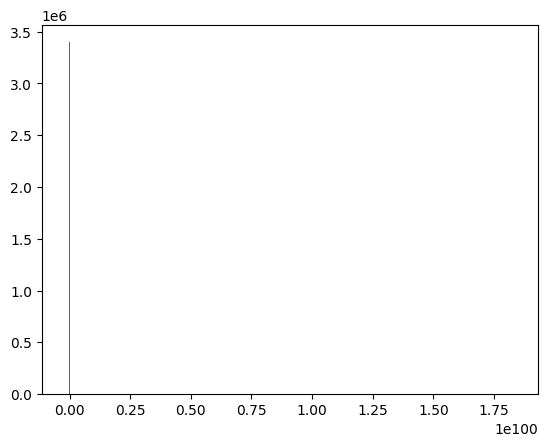

In [14]:
import matplotlib.pyplot as plt
plt.hist(wtf, bins=10_000)

In [18]:
def evaluate_imputation(*, original_df: pd.DataFrame, imputed_df: pd.DataFrame) -> pd.Series:    
    mask = original_df.isnull()
    return ((original_df[mask] - imputed_df[mask]) ** 2).mean()

In [19]:
print(
    "=====> MSE of global bf-xs imputation:",
    evaluate_imputation(original_df=full_data.to_pandas(), imputed_df=data_imputed.to_pandas()),
    "<====="
)

=====> MSE of global bf-xs imputation: AM                    NaN
AbnormalAccruals      NaN
Accruals              NaN
AnnouncementReturn    NaN
AssetGrowth           NaN
                     ... 
roaq                  NaN
yyyymm                NaN
zerotrade             NaN
zerotradeAlt1         NaN
zerotradeAlt12        NaN
Length: 107, dtype: object <=====


In [20]:
# Save model to avoid recomputation
data_imputed.write_csv(get_data_file_path("imputed_bf_xs_dataset.csv"))

In [21]:
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(np.clip(full_data.drop("permno", "yyyymm", "date").to_numpy(), -1e100, 1e100))

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [23]:
X_scaled = pl.DataFrame(X_scaled, schema=full_data.drop("permno", "yyyymm", "date").columns).with_row_count("index").join(full_data.with_row_count("index").select(["index", "permno", "yyyymm", "date"]), on="index")
X_scaled = X_scaled.drop("index")

/var/folders/qk/3qb7y7bs23l46_jb_xbrk_zw0000gn/T/ipykernel_59967/2722902737.py:1: DeprecationWarning: `with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  X_scaled = pl.DataFrame(X_scaled, schema=full_data.drop("permno", "yyyymm", "date").columns).with_row_count("index").join(full_data.with_row_count("index").select(["index", "permno", "yyyymm", "date"]), on="index")


In [24]:
X_scaled

AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BidAskSpread,BookLeverage,CF,CashProd,ChEQ,ChInv,ChInvIA,ChNNCOA,ChNWC,ChTax,ConvDebt,CoskewACX,Coskewness,CredRatDG,DebtIssuance,DelCOA,DelCOL,DelEqu,DelFINL,DelLTI,DelNetFin,DivInit,DivOmit,DolVol,EBM,EarningsSurprise,…,PctTotAcc,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,RDIPO,RDS,RealizedVol,ResidualMomentum,ReturnSkew,ReturnSkew3F,RoE,SP,ShareIss1Y,ShareRepurchase,Spinoff,Tax,TotalAccruals,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dNoa,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret,permno,yyyymm,date
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str
1.2618e-16,-1.8651e-17,-1.3579e-16,-4.4924e-17,4.3038e-17,-1.0093e-15,4.7654e-17,-9.3312e-20,1.5116e-16,-1.2834e-15,-1.2378e-17,1.1250e-16,0.0,-3.2056e-18,-1.5092e-18,7.2720e-17,0.0,9.8005e-20,-2.1511e-18,-3.2419e-18,1.8678e-19,-5.1809e-17,-8.1167e-17,9.5015e-16,-3.3995e-17,2.9874e-16,-2.2082e-16,2.0930e-17,-5.4793e-17,7.1162e-17,-5.2313e-17,0.0,-0.143049,0.066935,3.0781e-16,3.7326e-19,-5.9561e-19,…,-4.1901e-17,-1.7745e-16,1.6778e-18,-1.1995e-15,-1.1549e-16,2.6169e-17,-0.104368,2.0683e-16,-2.353356,-2.50221,3.6869e-19,0.0,3.6013e-17,-6.8344e-16,-0.189255,-3.9414e-17,1.9767e-17,-2.4335e-17,1.5514e-17,-4.8062e-17,-5.7924e-16,1.3140e-16,-0.293597,5.8273e-18,-6.9127e-17,0.0,0.0,-1.5107e-16,-2.0026e-16,-1.6448e-16,0.046406,0.770903,-0.026803,-9.8200e-18,10000,"""198601""","""1986-01-31"""
1.2618e-16,-1.8651e-17,-1.3579e-16,-4.4924e-17,4.3038e-17,-1.0093e-15,4.7654e-17,-9.3312e-20,1.5116e-16,-1.2834e-15,-1.2378e-17,1.1250e-16,0.0,-3.2056e-18,-1.5092e-18,7.2720e-17,0.0,9.8005e-20,-2.1511e-18,-3.2419e-18,1.8678e-19,-5.1809e-17,-8.1167e-17,9.5015e-16,-3.3995e-17,2.9874e-16,-2.2082e-16,2.0930e-17,-5.4793e-17,7.1162e-17,-5.2313e-17,0.0,-0.143049,0.066935,3.0781e-16,3.7326e-19,-5.9561e-19,…,-4.1901e-17,-1.7745e-16,1.6778e-18,-1.1995e-15,-1.1549e-16,2.6169e-17,0.002903,2.0683e-16,1.008449,1.213528,3.6869e-19,0.0,3.6013e-17,-6.8344e-16,-0.189255,-3.9414e-17,1.9767e-17,-2.4335e-17,1.5514e-17,-4.8062e-17,-5.7924e-16,1.3140e-16,-0.186203,5.8273e-18,-6.9127e-17,0.0,0.0,-1.5107e-16,-0.390956,-1.6448e-16,1.485654,0.998495,-0.026803,-1.507075,10000,"""198602""","""1986-02-28"""
1.2618e-16,-1.8651e-17,-1.3579e-16,-4.4924e-17,4.3038e-17,-1.0093e-15,4.7654e-17,-9.3312e-20,1.5116e-16,-1.2834e-15,-1.2378e-17,1.1250e-16,0.0,-3.2056e-18,-1.5092e-18,7.2720e-17,0.0,9.8005e-20,-2.1511e-18,-3.2419e-18,1.8678e-19,-5.1809e-17,-8.1167e-17,9.5015e-16,-3.3995e-17,2.9874e-16,-2.2082e-16,2.0930e-17,-5.4793e-17,7.1162e-17,-5.2313e-17,0.0,-0.143049,0.066935,0.947975,3.7326e-19,-5.9561e-19,…,-4.1901e-17,-1.7745e-16,1.6778e-18,-1.1995e-15,-1.1549e-16,2.6169e-17,-0.039487,2.0683e-16,-1.729877,-1.143943,3.6869e-19,0.0,3.6013e-17,-6.8344e-16,-0.189255,-3.9414e-17,1.9767e-17,-2.4335e-17,1.5514e-17,-4.8062e-17,-5.7924e-16,1.3140e-16,-0.138689,5.8273e-18,-6.9127e-17,0.0,0.0,-1.5107e-16,-0.390956,-1.6448e-16,-1.998679,0.760043,-0.026803,2.016954,10000,"""198603""","""1986-03-31"""
1.2618e-16,-1.8651e-17,-1.3579e-16,-4.4924e-17,4.3038e-17,-1.0093e-15,4.7654e-17,-9.3312e-20,1.5116e-16,-1.2834e-15,-1.2378e-17,1.1250e-16,0.0,-3.2056e-18,-1.5092e-18,7.2720e-17,0.0,9.8005e-20,-2.1511e-18,-3.2419e-18,1.8678e-19,-5.1809e-17,-8.1167e-17,9.5015e-16,-3.3995e-17,2.9874e-16,-2.2082e-16,2.0930e-17,-5.4793e-17,7.1162e-17,-5.2313e-17,0.0,-0.143049,0.066935,1.314473,3.7326e-19,-5.9561e-19,…,-4.1901e-17,-1.7745e-16,1.6778e-18,-1.1995e-15,-1.1549e-16,2.6169e-17,0.064741,2.0683e-16,0.494883,0.267115,3.6869e-19,0.0,3.6013e-17,-6.8344e-16,-0.189255,-3.9414e-17,1.9767e-17,-2.4335e-17,1.5514e-17,-4.8062e-17,-5.7924e-16,1.3140e-16,0.082222,5.8273e-18,-6.9127e-17,0.0,0.0

In [25]:
X_scaled.write_csv(get_data_file_path("simple_mean_imputed_dataset.csv"))

## 4. Processing

In [34]:
data_imputed = pl.read_csv(get_data_file_path("imputed_bf_xs_dataset.csv"), dtypes={"yyyymm": pl.String})
data_imputed = data_imputed.rename({"Price": "log_price"})
data_imputed = data_imputed.with_columns(pl.Series("price", np.exp(-data_imputed["log_price"])))
data_imputed = data_imputed.sort(["permno", "date"], maintain_order=True)
data_imputed

AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BidAskSpread,BookLeverage,CF,CashProd,ChEQ,ChInv,ChInvIA,ChNNCOA,ChNWC,ChTax,ConvDebt,CoskewACX,Coskewness,CredRatDG,DebtIssuance,DelCOA,DelCOL,DelEqu,DelFINL,DelLTI,DelNetFin,DivInit,DivOmit,DolVol,EBM,EarningsSurprise,…,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,RDIPO,RDS,RealizedVol,ResidualMomentum,ReturnSkew,ReturnSkew3F,RoE,SP,ShareIss1Y,ShareRepurchase,Spinoff,Tax,TotalAccruals,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dNoa,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,log_price,Size,ret,permno,yyyymm,date,price
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,f64
7.001128,0.006849,0.037038,0.027895,-0.200706,-0.933438,4.365937,-1.474361,1.558752,1.199701,-0.011071,0.031711,-3.55688,-0.369301,16.417263,-1.57609,-0.009028,-4.0202e9,-0.026663,-0.011968,-0.018995,-0.155542,0.203796,0.325541,-0.021278,-0.469517,-0.024636,-0.017632,-0.049977,-0.017856,-0.002983,-0.011635,0.0,0.0,-1.876211,-0.783592,1.8655e10,…,0.398978,-0.201488,1.316417,-0.009136,-53.169038,-0.065278,-0.059397,-2.23832,-2.103353,-0.312708,3.224296,-0.382112,0.262342,0.0,1.039741,0.004562,-5.508604,-0.442826,-11.488449,-0.008308,-0.122807,-0.005234,-0.018525,-0.102385,-0.048615,-0.031407,1.42601,1.513613,1.347789,0.0,-1.475907,-9.686575,0.164573,10000,"""198601""","""1986-01-31""",4.375
4.422268,0.004699,0.040654,-0.02882,-0.244965,-0.917169,3.137262,0.435059,1.024039,0.902381,-0.000944,0.021297,-6.089692,-0.158117,22.61442,-1.440656,-0.005389,-5.9807e9,-0.005398,0.005968,0.007321,-0.111807,0.166011,0.23915,-0.016656,-0.47921,-0.015011,-0.015161,-0.013843,-0.030942,-0.008467,-0.020292,0.0,0.0,-2.24073,1.32087,-7.8126e9,…,0.422778,1.427154,1.739605,-0.017578,-84.621812,-0.031004,-0.014548,0.729555,0.810187,-1.011627,2.513864,-0.290552,0.307018,0.0,0.99067,0.009428,-1.258062,-0.324097,-5.877647,-0.006366,-0.127155,-0.003488,-0.039211,-0.128668,-0.043868,-0.028472,1.054238,4.7852e-8,1.01621,25.7143,-1.178655,-9.389323,-0.257143,10000,"""198602""","""1986-02-28""",3.25
2.101274,0.006433,0.043412,0.050167,-0.267865,-0.816072,2.495356,0.496326,1.147037,0.905618,-0.003319,0.023313,-7.34694,-0.055169,-6.316874,-1.423873,-0.004868,-3.5340e9,-0.007126,0.005333,0.025869,-0.113378,0.107146,0.20675,-0.013424,-0.461953,-0.014142,-0.015621,0.012585,-0.037918,-0.005984,-0.033739,0.0,0.0,0.255134,1.102539,9.4179e10,…,0.481087,0.893275,1.726885,-0.016114,-23.049943,-0.044548,-0.021796,-1.6879,-1.038325,-1.508857,1.476825,-0.229304,0.274268,0.0,0.929094,0.017763,-1.580617,-0.061587,-3.969031,-0.005027,-0.12966,-0.002715,-0.015002,-0.152456,-0.03828,-0.033975,1.385354,1.0234e-7,1.393421,-36.5385,-1.490091,-9.700759,0.365385,10000,"""198603""","""1986-03-31""",4.4375
3.169009,0.005269,0.04242,-0.003592,-0.266767,-0.834151,3.099862,0.53572,1.026895,0.85097,-0.000809,0.023431,-7.358708,-0.102963,10.225437,-1.423441,-0.00499,-5.8132e9,-0.005241,0.006474,0.01866,-0.105609,0.130415,0.21934,-0.011792,-0.461921,-0.014265,-0.015567,0.006762,-0.03694,-0.007377,-0.030199,0.0,0.0,1.3126723,1.334835,5.7480e10,…,0.489339,1.563873,1.793533,-0.01845,-33.984111,-0.011246,0.01125,0.276167,0.068097,-1.465322,2.05432,-0.25461,0.273349,0.0,0.922286,0.016857,-0.985141,-0.195738,-3.752943,-0.004993,-0.13547,0.000877,-0.043818,-0.147269,-0.039747,-0.032348,1.632386,7.4675e-8,1.578947,9.8592,-1.386294,-9.627207,-0.098592,10000,"""198604""","""1986-04-30""",4.0
7.097098,0.010119,0.042715,-0.002707,-0.247014,-0.896225,4.196712,-0.882462,1.428231,1.099101,-0.009675,0.033078,-5.42698,-0.402165,24.405517,-1.565928,-0.006597,-6.4724e9,-0.021,-0.004227,-0.00599,-0.140535,0.175691,0.290917,-0.01717,-0.455436,-0.018972,-0.017602,-0.024521,-0.02513

In [ ]:
def run_models_and_plot(df, target_column):
    # Separate features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and fit models
    models = [
        LinearRegression(),
        Ridge(),
        Lasso(alpha=0.1),
        RandomForestRegressor(),
        AdaBoostRegressor(),
        XGBRegressor(objective="reg:squarederror")
    ]
    model_names = ["LinearRegression", "Ridge", "Lasso", "RandomForestRegressor", "AdaBoostRegressor", "XGBRegressor"]

    # Make predictions using each model and plot observed vs fitted values
    for model, name in zip(models, model_names):
        model.fit(X_train, y_train)
        if name == "Lasso":
            print(model.coef_)
        predictions = model.predict(X_test)

        # Plot observed vs fitted values
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, predictions)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
        plt.xlabel("Observed")
        plt.ylabel("Fitted")
        plt.title(name)
        plt.show()

run_models_and_plot(listings_1, "price")

In [ ]:
class NeuralNetwork(nn.Module):
    pass